# - Scenario run: keeping observed shade values in the whole reach and add 25ft veg buffer to each 500km land cover sheet
- Find the top 10 reaches from this scenario and add that land cover to a scenario - report the change in hours or days above july thermal maximum


In [4]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
import numpy as np
from scipy.integrate import simps
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

In [5]:
#reading in data with relative paths so that it can be used by others who clone repository from github
script_dir = os.getcwd()

# the baseline were useing for treeplanting scenatio is all grass and its been extended 5km 
base_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'baseline_vegetation', 'july_baseline_extended_5day'))

#Temperature Observations folder
observed_temp_path = os.path.abspath(os.path.join(script_dir, 'observations', 'TemperatureDataObs'))
#Temperature observations
obs = pd.read_csv(os.path.join(observed_temp_path, 'HourlySummer23Master_riverkm.csv'))

#reading in a model run without topographic shading, for use in determining whether a reach is forested or not
notopo_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'notopo_models', 'July_notopo_extended'))

#lc data scenario with buffer, to be used for adding forest to previously foresgrassyted areas
buffer_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_inputs', 'vegetation_buffers', 'july_allforest_extended'))


In [6]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
#obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
obs_clip_mean = obs_clip.resample('D').mean()

In [7]:
notopo_shade_df = pd.read_csv(os.path.join(notopo_source_folder, 'outputs\Shade.csv'), skiprows=6,
         usecols=range(1, 187))
notopo_shade_df.columns = [float(col) for col in notopo_shade_df.columns]
notopo_shade_df = notopo_shade_df.mean()
notopo_shade_df = pd.DataFrame(notopo_shade_df)
notopo_shade_df = notopo_shade_df.reset_index()
#notopo_shade_df.index = obs_clip_mean.index
notopo_shade_df.rename(columns={'index': 'NODE_ID', 0 : 'July Shade'}, inplace=True)


# Heatsource iteration:
- this code reads in the observed baseline model, and iterates through 500m reaches adding shade to the existing landcover data 
- can take a while to run if doing so on monthly models

In [6]:
## add trees in 500m reach, widen if the node isnt previously forested

landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(notopo_source_folder, 'inputs\WFK23_lcdata.csv'))
forestlandcover = pd.read_csv(os.path.join(buffer_source_folder, 'inputs\WFK23_lcdata.csv'))
forestmorphology = pd.read_csv(os.path.join(buffer_source_folder, 'inputs\WFK23_morphology.csv'))


changed_nodes = {}

for index, row in landcover.iterrows():
    km_start = row['STREAM_KM']
    
    #dont keep simulating once model gets to the extended portion
    if km_start == 5.0:
        break
    
    if isinstance(km_start, float) and km_start % .5 == 0:
        landcover_km = landcover.copy()# Create a copy of landcover DataFrame
        morphology_km = morphology.copy()
        
        
        print(km_start)
        #print('true')
        # if km_start == 18.0:
        #     continue
        km_end = km_start - .5  # Assuming km_end is one kilometer ahead of km_start
        # Copy base model folder and rename it
        original_folder_path = base_source_folder
        # You can adjust the folder name as needed
        new_folder_path = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_outputs', 'observed_baseline', 'baseline_treeplanting_widen20_7mtree_5day', f'treeplanting_widen20_7mtree_{km_start}'))
        shutil.copytree(original_folder_path, new_folder_path) 


        landcover = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'))
        morphology = pd.read_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'))
        # change controlfile to reflect reach folder
        control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
        control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
        control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
        control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

        reach_shade = notopo_shade_df[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
        print(km_start)
        changed_nodes[km_start] = []

        for index, row in reach_shade.iterrows():
            # make landcover in 500m treatment reach equal the landcover in the forest buffer we want to use
            landcover_km.loc[index, landcover_km.columns[8:49]] = forestlandcover.loc[index, forestlandcover.columns[8:49]]
            landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)
            
            # make the wifth in 500m treatment reach equal the width  in the forest buffer we want to use
            morphology_km.loc[index, morphology_km.columns[5:6]] = forestmorphology.loc[index, forestmorphology.columns[5:6]]
            morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            #We dont multiply the morphology
            changed_nodes[km_start].append(index)


        os.chdir(new_folder_path)
        subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)


23.5
23.5
23.0
23.0
22.5
22.5
22.0
22.0
21.5
21.5
21.0
21.0
20.5
20.5
20.0
20.0
19.5
19.5
19.0
19.0
18.5
18.5
18.0
18.0
17.5
17.5
17.0
17.0
16.5
16.5
16.0
16.0
15.5
15.5
15.0
15.0
14.5
14.5
14.0
14.0
13.5
13.5
13.0
13.0
12.5
12.5
12.0
12.0
11.5
11.5
11.0
11.0
10.5
10.5
10.0
10.0
9.5
9.5
9.0
9.0
8.5
8.5
8.0
8.0
7.5
7.5
7.0
7.0
6.5
6.5
6.0
6.0
5.5
5.5


In [22]:
landcover.loc[10, landcover.columns[8:49]]

LC_T0_S0    5.0
LC_T1_S1    5.0
LC_T1_S2    4.0
LC_T1_S3   -2.0
LC_T1_S4   -2.0
LC_T1_S5   -2.0
LC_T2_S1   -2.0
LC_T2_S2   -2.0
LC_T2_S3   -2.0
LC_T2_S4   -2.0
LC_T2_S5   -2.0
LC_T3_S1    5.0
LC_T3_S2   -1.0
LC_T3_S3   -2.0
LC_T3_S4   -2.0
LC_T3_S5   -2.0
LC_T4_S1   -1.0
LC_T4_S2   -1.0
LC_T4_S3   -1.0
LC_T4_S4   -2.0
LC_T4_S5   -2.0
LC_T5_S1   -1.0
LC_T5_S2   -2.0
LC_T5_S3   -2.0
LC_T5_S4   -2.0
LC_T5_S5    4.0
LC_T6_S1    5.0
LC_T6_S2   -1.0
LC_T6_S3   -2.0
LC_T6_S4   -2.0
LC_T6_S5   -2.0
LC_T7_S1    5.0
LC_T7_S2    7.0
LC_T7_S3    7.0
LC_T7_S4   -1.0
LC_T7_S5   -1.0
LC_T8_S1    7.0
LC_T8_S2    7.0
LC_T8_S3    7.0
LC_T8_S4   -2.0
LC_T8_S5   -2.0
Name: 10, dtype: float64

In [23]:
forestlandcover.loc[10, forestlandcover.columns[8:49]]

LC_T0_S0   -1.0
LC_T1_S1   -6.0
LC_T1_S2   -6.0
LC_T1_S3   -6.0
LC_T1_S4   -6.0
LC_T1_S5   -6.0
LC_T2_S1   -1.0
LC_T2_S2   -1.0
LC_T2_S3   -1.0
LC_T2_S4    4.0
LC_T2_S5    4.0
LC_T3_S1   -1.0
LC_T3_S2   -6.0
LC_T3_S3   -6.0
LC_T3_S4   -6.0
LC_T3_S5   -6.0
LC_T4_S1   -1.0
LC_T4_S2   -6.0
LC_T4_S3   -6.0
LC_T4_S4   -6.0
LC_T4_S5   -6.0
LC_T5_S1   -1.0
LC_T5_S2   -1.0
LC_T5_S3   -1.0
LC_T5_S4   -6.0
LC_T5_S5   -6.0
LC_T6_S1   -6.0
LC_T6_S2   -6.0
LC_T6_S3   -6.0
LC_T6_S4   -6.0
LC_T6_S5    3.0
LC_T7_S1   -6.0
LC_T7_S2    3.0
LC_T7_S3   -6.0
LC_T7_S4   -6.0
LC_T7_S5   -6.0
LC_T8_S1   -6.0
LC_T8_S2   -6.0
LC_T8_S3   -6.0
LC_T8_S4   -6.0
LC_T8_S5   -6.0
Name: 10, dtype: float64

In [6]:
forestlandcover.loc[30:35,forestlandcover.columns[8:49]]

LC_T0_S0  LC_T1_S1  LC_T1_S2  LC_T1_S3  LC_T1_S4  LC_T1_S5  LC_T2_S1  \
30        -1         5         5         4         4        -6        -1   
31        10        10        -6         5         5         5        10   
32        10        10         4        -6        -6        -6        -1   
33        -1        -1        -6        -6         4         4        -1   
34        -1        -1         5         5         5        -6        -1   
35        -1        -6         3        -6        -6        -6        -1   

    LC_T2_S2  LC_T2_S3  LC_T2_S4  ...  LC_T7_S1  LC_T7_S2  LC_T7_S3  LC_T7_S4  \
30         6         6         4  ...        -1        -1        10        10   
31        10        -6         4  ...         9         9         9        10   
32        -1        -1        -1  ...        10        -1        10        10   
33        -1        -1        -6  ...        -1        -1        -6        -6   
34        -1        -6        -6  ...        -1        -1         7         7   
35         3         3        -6  ...        -1        -6        -6        -6   

    LC_T7_S5  LC_T8_S1  LC_T8_S2  LC_T8_S3  LC_T8_S4  LC_T8_S5  
30        10        -1        -6        10        10        10  
31        10         9        -6         4         4        -6  
32        -6        10        -2        -6        -6        -6  
33        -6        -1        -6         4        -6        -6  
34        -6        -1        -6         5         5         5  
35         5        -6        -6        -6        -6        -6  

[6 rows x 41 columns]

In [7]:
landcover.loc[30:35,landcover.columns[8:49]]

LC_T0_S0  LC_T1_S1  LC_T1_S2  LC_T1_S3  LC_T1_S4  LC_T1_S5  LC_T2_S1  \
30        -1         5         5         4         4        -2        -1   
31        10        10        -2         5         5         5        10   
32        10        10         4        -2        -2        -2        -1   
33        -1        -1        -2        -2         4         4        -1   
34        -1        -1         5         5         5        -2        -1   
35        -1        -2         3        -2        -2        -2        -1   

    LC_T2_S2  LC_T2_S3  LC_T2_S4  ...  LC_T7_S1  LC_T7_S2  LC_T7_S3  LC_T7_S4  \
30         6         6         4  ...        -1        -1        10        10   
31        10        -2         4  ...         9         9         9        10   
32        -1        -1        -1  ...        10        -1        10        10   
33        -1        -1        -2  ...        -1        -1        -1        -2   
34        -1        -2        -2  ...        -1        -1         7         7   
35         3         3        -2  ...        -1        -2        -2        -2   

    LC_T7_S5  LC_T8_S1  LC_T8_S2  LC_T8_S3  LC_T8_S4  LC_T8_S5  
30        10        -1        -2        10        10        10  
31        10         9        -2         4         4        -2  
32        -2        10        -2        -2        -2        -2  
33        -2        -1        -2         4        -2        -2  
34        -2        -1        -2         5         5         5  
35         5        -2        -2        -2        -2        -2  

[6 rows x 41 columns]

## Plotting heatsource results
- plots the results of each 500m reach vs the baseline
- adds attributes about the reach to multiple dictionaries (width, velocity, existing shade, post-scenario shade, change in shade) for use in regression analysis


In [8]:
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
#plotting from bankbuffer

hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left') 
daily_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left') 
#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled_mean = upstreamconstant_df.resample('D').mean()

upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()



In [9]:
upstreamconstant_df

23.5     23.4     23.3     23.2     23.1     23.0  \
datetime                                                                   
2023-07-01 00:00:00  20.817  20.8091  20.8121  20.8108  20.8063  20.8090   
2023-07-01 01:00:00  20.484  20.4639  20.4653  20.4579  20.4339  20.4231   
2023-07-01 02:00:00  20.150  20.1367  20.1434  20.1420  20.1250  20.1185   
2023-07-01 03:00:00  19.841  19.8290  19.8359  19.8356  19.8206  19.8151   
2023-07-01 04:00:00  19.484  19.4809  19.4957  19.5024  19.4958  19.4953   
...                     ...      ...      ...      ...      ...      ...   
2023-07-05 19:00:00  21.772  21.7338  21.7325  21.7238  21.7216  21.7265   
2023-07-05 20:00:00  21.342  21.3368  21.3613  21.3765  21.3932  21.4052   
2023-07-05 21:00:00  20.793  20.7972  20.8268  20.8452  20.8600  20.8723   
2023-07-05 22:00:00  20.246  20.2582  20.2927  20.3165  20.3372  20.3520   
2023-07-05 23:00:00  19.674  19.6933  19.7334  19.7624  19.7894  19.8080   

                        22.9     22.8     22.7     22.6  ...     0.9   \
datetime                                                 ...            
2023-07-01 00:00:00  20.8095  20.7518  20.8095  20.8102  ...  20.8128   
2023-07-01 01:00:00  20.3594  19.6958  19.7237  19.7365  ...  20.5312   
2023-07-01 02:00:00  20.0604  19.4074  19.4249  19.4283  ...  20.3018   
2023-07-01 03:00:00  19.7605  19.1198  19.1384  19.1420  ...  20.0888   
2023-07-01 04:00:00  19.4497  18.8246  18.8481  18.8540  ...  19.8614   
...                      ...      ...      ...      ...  ...      ...   
2023-07-05 19:00:00  21.6849  20.9694  20.9911  21.0023  ...  23.9448   
2023-07-05 20:00:00  21.3758  20.6838  20.7175  20.7323  ...  23.3778   
2023-07-05 21:00:00  20.8499  20.2034  20.2468  20.2649  ...  22.7348   
2023-07-05 22:00:00  20.3343  19.7191  19.7609  19.7785  ...  22.1202   
2023-07-05 23:00:00  19.7996  19.2245  19.2736  19.2952  ...  21.6217   

                        0.8      0.7      0.6      0.5      0.4      0.3   \
datetime                                                                    
2023-07-01 00:00:00  20.8131  20.8130  20.8128  20.8128  20.8131  20.8129   
2023-07-01 01:00:00  20.5317  20.5315  20.5306  20.5299  20.5307  20.5299   
2023-07-01 02:00:00  20.3019  20.3014  20.3000  20.2990  20.2993  20.2981   
2023-07-01 03:00:00  20.0892  20.0888  20.0876  20.0867  20.0871  20.0859   
2023-07-01 04:00:00  19.8649  19.8674  19.8687  19.8699  19.8722  19.8727   
...                      ...      ...      ...      ...      ...      ...   
2023-07-05 19:00:00  23.9863  24.0288  24.0723  24.1157  24.1570  24.2001   
2023-07-05 20:00:00  23.4162  23.4549  23.4940  23.5333  23.5720  23.6113   
2023-07-05 21:00:00  22.7735  22.8116  22.8492  22.8869  22.9255  22.9627   
2023-07-05 22:00:00  22.1544  22.1885  22.2225  22.2570  22.2929  22.3278   
2023-07-05 23:00:00  21.6475  21.6734  21.6993  21.7261  21.7546  21.7823   

                        0.2      0.1      0.0   
datetime                                        
2023-07-01 00:00:00  20.8128  20.8127  20.8127  
2023-07-01 01:00:00  20.5288  20.5277  20.5265  
2023-07-01 02:00:00  20.2966  20.2951  20.2937  
2023-07-01 03:00:00  20.0843  20.0826  20.0811  
2023-07-01 04:00:00  19.8725  19.8720  19.8713  
...                      ...      ...      ...  
2023-07-05 19:00:00  24.2432  24.2841  24.3161  
2023-07-05 20:00:00  23.6503  23.6875  23.7167  
2023-07-05 21:00:00  22.9992  23.0338  23.0607  
2023-07-05 22:00:00  22.3622  22.3950  22.4207  
2023-07-05 23:00:00  21.8099  21.8364  21.8574  

[120 rows x 236 columns]

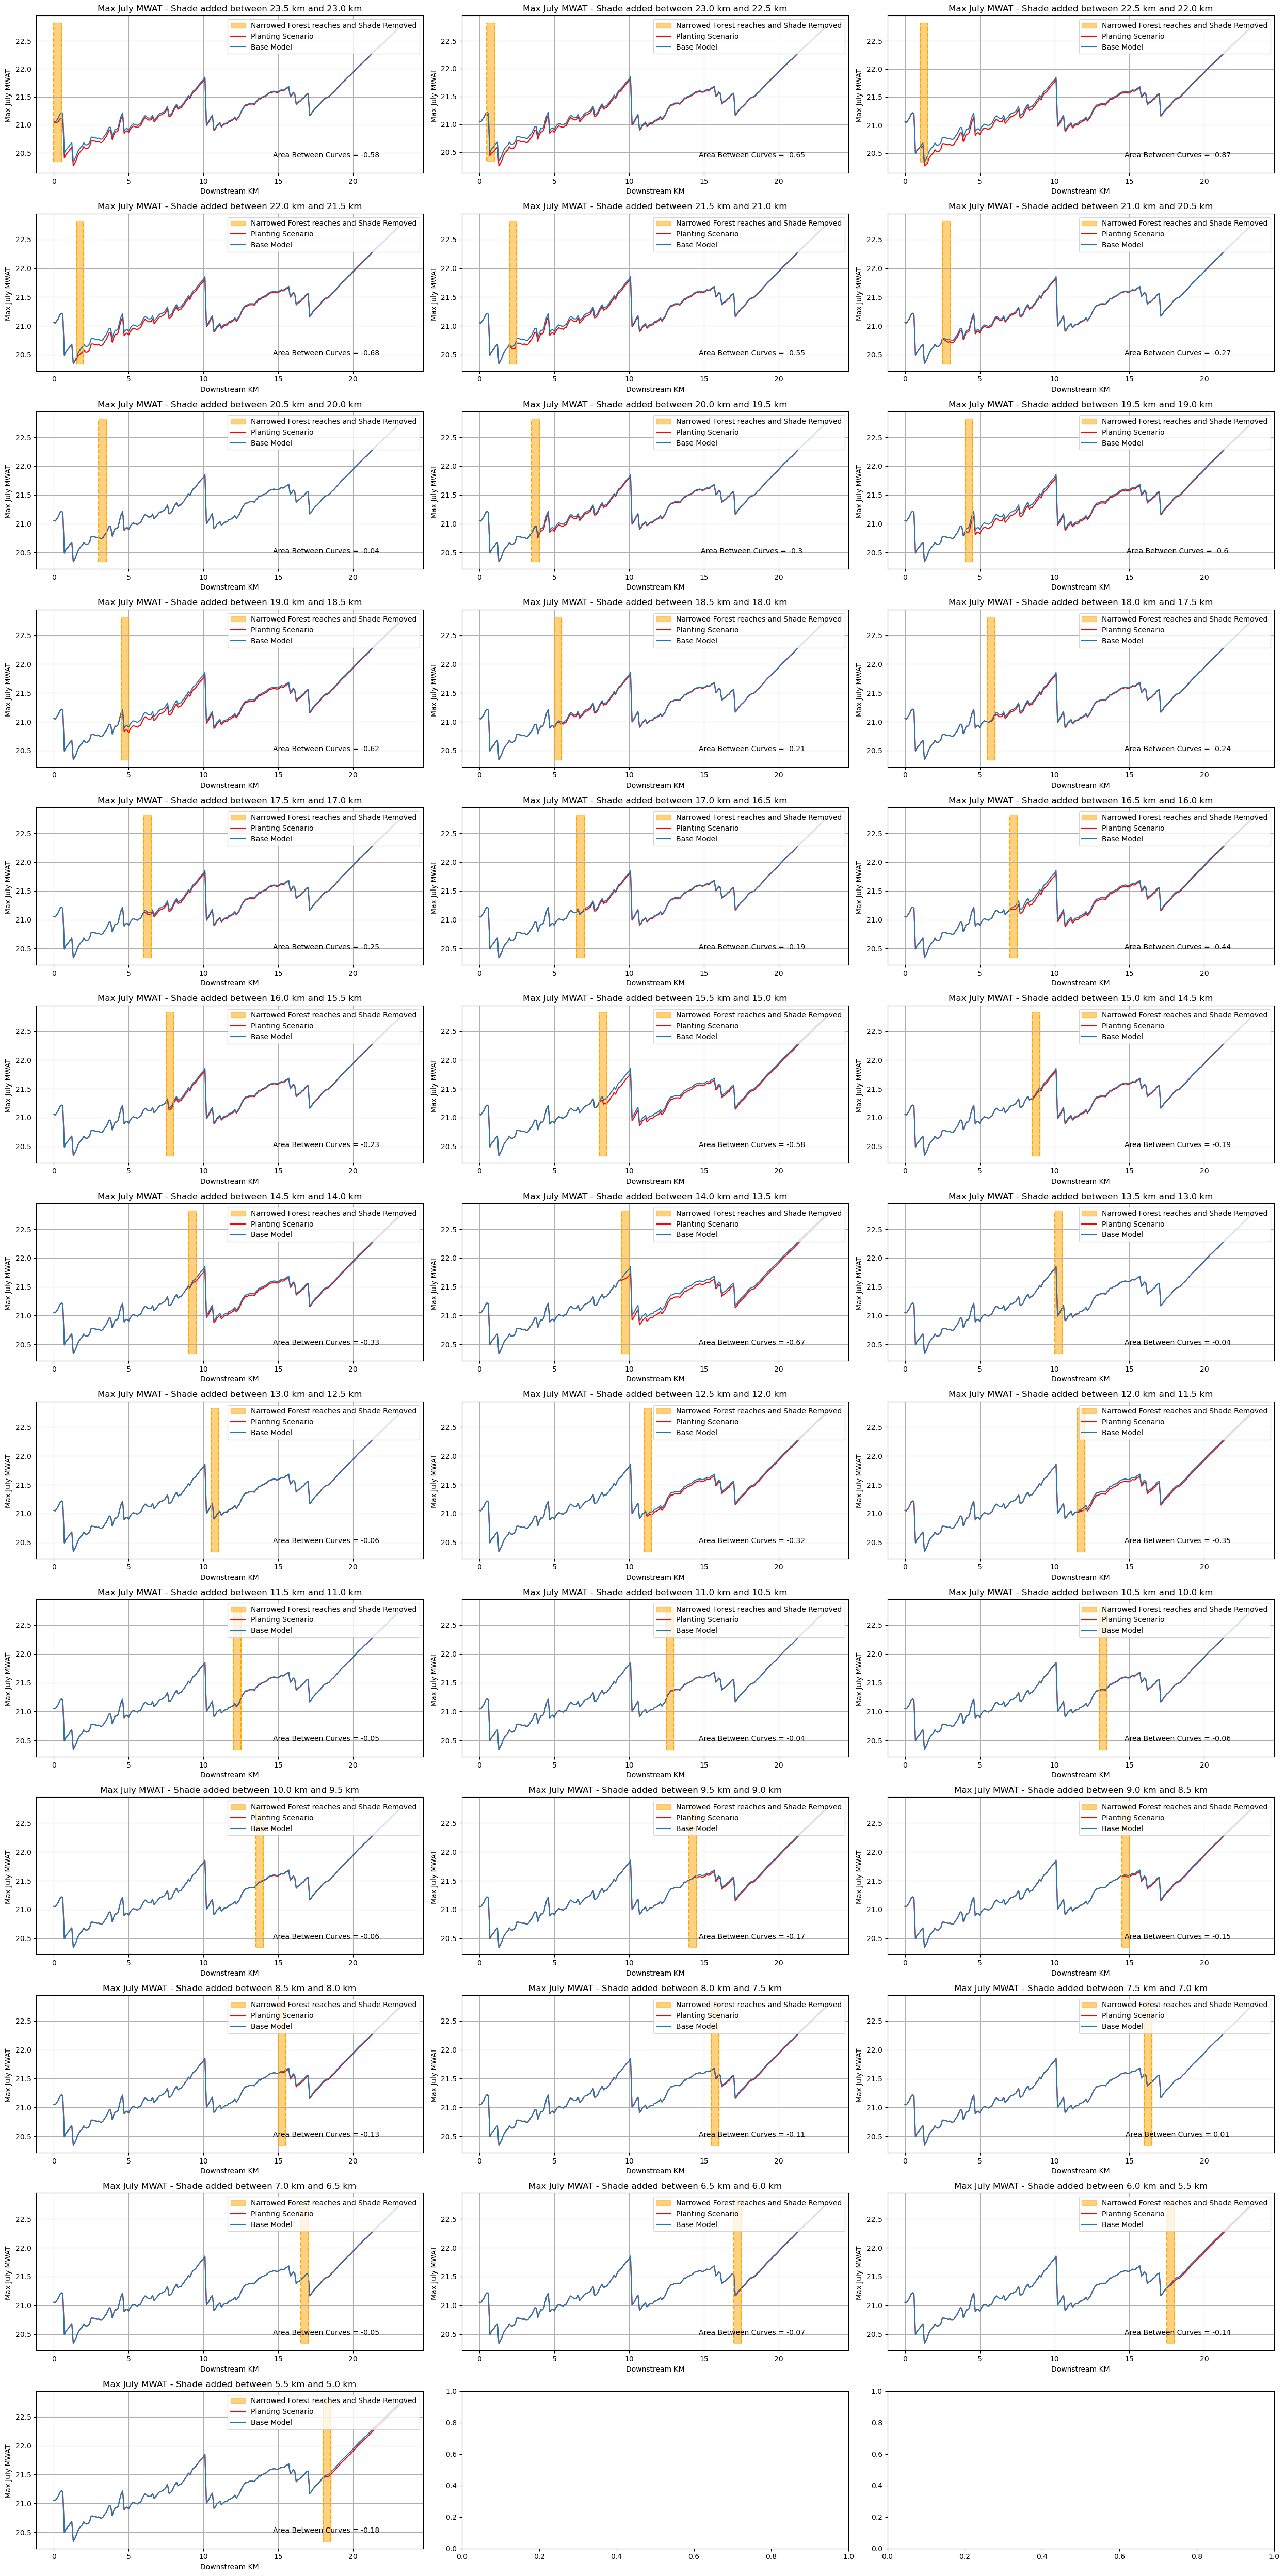

In [10]:
###30% widening Results###
values = [23.5-(x / 2) for x in range(0, 37)]

obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'08-01-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]


obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
#plotting from bankbuffer
fig, axes = plt.subplots(13, 3, figsize=(25, 50))

    # Flatten the axes array to make it easier to iterate over
axes = axes.flatten()
hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left') 
daily_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left') 
#upstreamconstant_df = 
upstreamconstant_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
upstreamconstant_df.columns = [float(col) for col in upstreamconstant_df.columns]
upstreamconstant_df.index = obs_clip.index
# mean july temperature summary
upstreamconstant_modeled = upstreamconstant_df.resample('D').mean()
upstreamconstant_modeled = upstreamconstant_modeled.mean()    
upstreamconstant_modeled = pd.DataFrame(upstreamconstant_modeled)
upstreamconstant_modeled = upstreamconstant_modeled.reset_index()
upstreamconstant_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
obs_rolling_avg = upstreamconstant_modeled_mean.rolling(window=7).max()
obs_max_mwat = obs_rolling_avg.max()
upstreamconstant_modeled['Max MWAT'] = obs_max_mwat.values

#base shade scenario
base_shade_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 237))
base_hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='H', inclusive='left')  # Closed left ensures end date is exclusive
base_shade_df.columns = [float(col) for col in base_shade_df.columns]
base_shade_df.index = daily_index
base_shade = base_shade_df.mean()
base_shade = pd.DataFrame(base_shade)
base_shade = base_shade.reset_index()
base_shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)

# base width
base_width = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Hyd_WT.csv'), skiprows=6, usecols=range(1, 237))
base_width.columns = [float(col) for col in base_width.columns]
base_width = base_width.iloc[0]#.to_numpy()
base_width = pd.DataFrame(base_width)
base_width = base_width.reset_index()
base_width.rename(columns={'index': 'NODE_ID', 0 : 'Width'}, inplace=True)

#dicts to hold differneces between scenarios
effectiveness_difference = {}
reach_shade_base = {}
reach_shade_scenario = {}
reach_shade_change = {}
reach_velocity = {}
reach_width_sim = {}
reach_width_base = {}
reach_width_change = {}

reach_depth = {}
reach_widthdepth = {}
reach_azimuth = {}
reach_gradient = {}
count = 0
for i in values:
    count += 1
    km_start = i
    km_end = i-.5
    if km_start == 0:
        continue
    else:
        # km_start = i+1
        # km_end = i
        reach_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_outputs', 'observed_baseline', 'baseline_treeplanting_widen20_7mtree_5day', f'treeplanting_widen20_7mtree_{i}'))
        modeled_tw_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6, usecols=range(1, 237))
        modeled_tw_df.columns = [float(col) for col in modeled_tw_df.columns]
        modeled_tw_df.index = obs_clip.index
        # mean july temperature summary
        mean_daily_modeled = modeled_tw_df.resample('D').mean()
        mean_july_modeled = mean_daily_modeled.mean()    
        mean_july_modeled = pd.DataFrame(mean_july_modeled)
        mean_july_modeled = mean_july_modeled.reset_index()
        mean_july_modeled.rename(columns={'index': 'NODE_ID', 0 : 'Mean July Temp'}, inplace=True)
        sim__rolling_avg = mean_daily_modeled.rolling(window=7).max()
        sim_max_mwat = sim__rolling_avg.max()
        mean_july_modeled['Max MWAT'] = sim_max_mwat.values
        
        #doing integration
        x = mean_july_modeled['NODE_ID']
        y1 = mean_july_modeled['Mean July Temp']
        y2 = upstreamconstant_modeled['Mean July Temp']

        
        
        
        
        # Compute absolute difference between the curves
        abs_diff = np.abs(y1 - y2)

        # Use Simpson's rule for numerical integration
        area = simps(abs_diff, x)
        #changing sign of degree kilomters to be negative or positive based on if its cooling (negative) or warming (positive) from restoration
        if (upstreamconstant_modeled - mean_july_modeled ).mean()['Mean July Temp'] <= 0:
            area = area*-1
        area
        
        effectiveness_difference[km_start] = area
        
        #getting effective shade values
        control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
        cc_start = control_file.loc[7]['VALUE']
        cc_start = pd.to_datetime(cc_start)
        cc_end = control_file.loc[8]['VALUE']
        cc_end = pd.to_datetime(cc_end)
        scenario_shade_df = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 237))
        scenario_shade_df.columns = [float(col) for col in scenario_shade_df.columns]
        scenario_shade_df.index = daily_index
        shade = scenario_shade_df.mean()
        shade = pd.DataFrame(shade)
        shade = shade.reset_index()
        shade.rename(columns={'index': 'NODE_ID', 0 : 'Effective Shade %'}, inplace=True)
        reach = shade[(shade['NODE_ID'] <= km_start) & (shade['NODE_ID'] >=km_end)]
        base_reach = base_shade[(base_shade['NODE_ID'] <= km_start) & (base_shade['NODE_ID'] >=km_end)]
        #compare base shade to scenario shade
        reach_percent_increase = (base_reach - reach)/base_reach
        reach_difference = reach - base_reach

        reach_mean_percent_increase = reach_percent_increase['Effective Shade %'].mean()    
        #reach_shade[km_start] = reach_mean_percent_increase
        reach_shade_base[km_start] = base_reach['Effective Shade %'].mean()
        reach_shade_scenario[km_start] = reach['Effective Shade %'].mean()
        reach_shade_change[km_start] = reach_difference['Effective Shade %'].mean()

         #get reach azimuth
        azimuth = pd.read_csv(os.path.abspath(os.path.join(script_dir, 'scenarios','stream_azimuth.csv')))
        azimuth_reach = azimuth[(azimuth['STREAM_KM'] <= km_start) & (azimuth['STREAM_KM'] >=km_end)]
        azimuth_reach_mean = azimuth_reach['Azm'].mean()
        reach_azimuth[km_start] = abs(azimuth_reach_mean-180)
        
        #get reach gradient 
        gradient = pd.read_csv(os.path.abspath(os.path.join(script_dir, 'scenarios','stream_azimuth.csv')))
        gradient_reach = gradient[(gradient['STREAM_KM'] <= km_start) & (gradient['STREAM_KM'] >=km_end)]
        gradient_reach_mean = gradient_reach['GRADIENT'].mean()
        reach_gradient[km_start] = gradient_reach_mean

        #getting mean velocity
        velocity = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_Vel.csv'), skiprows=6, usecols=range(1, 237))
        velocity.columns = [float(col) for col in velocity.columns]
        sim_velocity = velocity.mean()#.to_numpy()
        sim_velocity = pd.DataFrame(sim_velocity)
        sim_velocity = sim_velocity.reset_index()
        sim_velocity.rename(columns={'index': 'NODE_ID', 0 : 'Velocity'}, inplace=True)
        velocity_reach = sim_velocity[(sim_velocity['NODE_ID'] <= km_start) & (sim_velocity['NODE_ID'] >=km_end)]
        reach_mean_velocity = velocity_reach['Velocity'].mean()
        reach_velocity[km_start] = reach_mean_velocity
        
        #Getting Width
        sim_width = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_WT.csv'), skiprows=6, usecols=range(1, 237))
        sim_width.columns = [float(col) for col in sim_width.columns]
        sim_width = sim_width.iloc[0]#.to_numpy()
        sim_width = pd.DataFrame(sim_width)
        sim_width = sim_width.reset_index()
        sim_width.rename(columns={'index': 'NODE_ID', 0 : 'Width'}, inplace=True)
        sim_width = sim_width[(sim_width['NODE_ID'] <= km_start) & (sim_width['NODE_ID'] >=km_end)]
        reach_width_sim[km_start] = sim_width['Width'].mean()

        base_width_reach = base_width[(base_width['NODE_ID'] <= km_start) & (base_width['NODE_ID'] >=km_end)]
        reach_width_base[km_start] = base_width_reach['Width'].mean()

        reach_width_change[km_start] = reach_width_sim[km_start] - reach_width_base[km_start]
        
        #getting depth
        sim_depth = pd.read_csv(os.path.join(reach_source_folder, 'outputs', 'Hyd_DA.csv'), skiprows=6, usecols=range(1, 237))
        sim_depth.columns = [float(col) for col in sim_depth.columns]
        sim_depth = sim_depth.iloc[0]#.to_numpy()
        sim_depth = pd.DataFrame(sim_depth)
        sim_depth = sim_depth.reset_index()
        sim_depth.rename(columns={'index': 'NODE_ID', 0 : f'Depth'}, inplace=True)
        sim_depth = sim_depth[(sim_depth['NODE_ID'] <= km_start) & (sim_depth['NODE_ID'] >=km_end)]
        reach_depth[km_start] = sim_depth['Depth'].mean()
        #width:depth
        reach_widthdepth[km_start] = (sim_width['Width'].mean()/sim_depth['Depth'].mean())
        #plotting
        # Create a new figure with a 3x3 grid of subplots

        shade_start = i
        #plt.figure()  # Create a new figure for each iteration  
        axes[count-1].fill_between([23.5 - km_start, 23.5 - km_end], upstreamconstant_modeled['Mean July Temp'].min(),upstreamconstant_modeled['Mean July Temp'].max(), color='orange', alpha = .5, label = 'Narrowed Forest reaches and Shade Removed')
        axes[count-1].plot(23.5-mean_july_modeled['NODE_ID'], mean_july_modeled['Mean July Temp'], label=f'Planting Scenario', color = 'red')
        axes[count-1].plot(23.5-upstreamconstant_modeled['NODE_ID'], upstreamconstant_modeled['Mean July Temp'], label='Base Model')
        #axes[count-1].set_title(f'Max July MWAT - Shade added between {23.5 - km_start} km and {23.5 - km_end} km')
        axes[count-1].set_title(f'Max July MWAT - Shade added between {km_start} km and {km_end} km')

        axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
        axes[count-1].set_ylabel('Max July MWAT ')  # Replace 'Y Label' with appropriate label
        axes[count-1].text(0.75, 0.1, f'Area Between Curves = {round(area,2)}', horizontalalignment='center', transform=axes[count-1].transAxes)

        # Plot the shade data on the second y-axis
        # axes[count-1] = axes[count-1].twinx()
        # axes[count-1].plot(23.5-shade.index, shade[0], label='Mean Solar Radiation Flux \n At Stream Surface', color='red', alpha = .5)
        # axes[count-1].set_ylabel('Mean Solar Radiation Flux \n At Stream Surface (W/m2)', color = 'red')
        # axes[count-1].tick_params(axis='y', colors='red')

        axes[count-1].vlines([23.5 - km_start, 23.5 - km_end], ymin = upstreamconstant_modeled['Mean July Temp'].min(), ymax = upstreamconstant_modeled['Mean July Temp'].max(),color = 'orange', linestyles = 'dashed')
        axes[count-1].grid(True) 
        axes[count-1].legend(loc = 'upper right')

        #axes[count-1].legend(loc = 'lower right')
        # axes[count-1].set_xlim([18.3 - km_end-2, 18.3 - km_start+2 ])


    #plt.show()
    #add vertical line where shade is added              
plt.tight_layout()
fig.patch.set_facecolor('white')

#plt.savefig(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/500m_run/narrow/reach_shaderemoval+narrow20.png')
plt.show()
#new_folder_name = f"folder_{km_start}"

# Adding scenario results to dataframes
- adds attributes from reach level scenarios ot dataframe
- joins the dataframe to a shapefile of all the reaches

In [11]:
nodes = gpd.read_file(os.path.abspath(os.path.join(script_dir, 'shp', 'centerline_500msplit.shp')))


In [12]:
#shapefile with spatial info for 500m restoration reaches
#nodes = gpd.read_file(os.path.abspath(os.path.join(script_dir, 'shp', 'centerline_500msplit.shp')))

#making dataframes from info about each restoration reach
reach_shadescenario_dict = pd.DataFrame(list(reach_shade_scenario.items()), columns=['Reach Start KM', 'SR Scenario'])
reach_shadebase_dict = pd.DataFrame(list(reach_shade_base.items()), columns=['Reach Start KM', 'SR Baseline'])
reach_velocity_dict = pd.DataFrame(list(reach_velocity.items()), columns=['Reach Start KM', 'Velocity'])
reach_width_dict = pd.DataFrame(list(reach_width_sim.items()), columns=['Reach Start KM', 'Width'])
reach_depth_dict = pd.DataFrame(list(reach_depth.items()), columns=['Reach Start KM', 'Depth'])
reach_widthdepth_dict = pd.DataFrame(list(reach_widthdepth.items()), columns=['Reach Start KM', 'Width:Depth'])
reach_shadedif_dict = pd.DataFrame(list(reach_shade_change.items()), columns=['Reach Start KM', 'SR Difference'])
reach_azimuth_dict = pd.DataFrame(list(reach_azimuth.items()), columns=['Reach Start KM', 'Mean Azimuth'])
reach_gradient_dict = pd.DataFrame(list(reach_gradient.items()), columns=['Reach Start KM', 'Gradient'])
reach_widthchange_dict = pd.DataFrame(list(reach_width_change.items()), columns=['Reach Start KM', 'Width'])




#creating df to add to 
dif_df_dict = pd.DataFrame(list(effectiveness_difference.items()), columns=['Reach Start KM', 'Degree Kilometers'])

#adding data from scenarios
dif_df_dict['Model Start KM'] = dif_df_dict['Reach Start KM']
dif_df_dict['Reach Start KM'] = dif_df_dict['Reach Start KM']-5
dif_df_dict['Mean velocity'] = reach_velocity_dict['Velocity']
dif_df_dict['Mean Azimuth'] = reach_azimuth_dict['Mean Azimuth']
dif_df_dict['Width'] = reach_width_dict['Width']
dif_df_dict['Depth'] = reach_depth_dict['Depth']
dif_df_dict['Width:Depth'] = reach_widthdepth_dict['Width:Depth']
dif_df_dict['Change in SR'] = reach_shadedif_dict['SR Difference']*100
dif_df_dict['Baseline SR'] = reach_shadebase_dict['SR Baseline'] *100
dif_df_dict['Scenario SR'] = reach_shadescenario_dict['SR Scenario']*100
dif_df_dict['absolute DK'] = abs(dif_df_dict['Degree Kilometers'])
dif_df_dict['Gradient'] = reach_gradient_dict['Gradient']
dif_df_dict['Width Change'] = reach_widthchange_dict['Width']


dif_df_dict['reach2'] = dif_df_dict.index


#dif_df_dict.drop(dif_df_dict.tail(1).index, inplace=True)
dif_df_dict['Distance Downstream'] = 18.5 - dif_df_dict['Reach Start KM']
dif_df_dict = dif_df_dict.sort_values('Degree Kilometers')
dif_df_dict.reset_index(drop=True, inplace=True)
dif_df_dict.index.name = 'Effectiveness Rank'
dif_df_dict.reset_index(inplace=True)
#dif_df_dict.index += 1
merged_gdf_dif = pd.merge(nodes, dif_df_dict[['Reach Start KM','Degree Kilometers', 'reach2', 'Width Change', 'absolute DK','Effectiveness Rank', 'Width', 'Baseline SR', 'Change in SR', 'Mean velocity']], left_on='reach2', right_on = 'reach2', how='left')
#merged_gdf_dif.drop(merged_gdf_dif['row'], axis=0, errors='ignore')

#merged_gdf_dif.to_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/extending_model/ranking_treeremoval.shp')
#dif_df_dict.sort_values(by = 'Effectiveness Rank')
#$merged_gdf_dif
merged_gdf_dif

Id  ORIG_FID  ORIG_SEQ  Shape_Leng  reach2  \
0    0         0         4  500.000119      34   
1    0         0         3  499.999985      35   
2    0         0         2  499.999924      36   
3    0         0         5  500.000039      33   
4    0         0         6  500.000046      32   
5    0         0         7  499.999965      31   
6    0         0         8  499.999909      30   
7    0         0         9  500.000054      29   
8    0         0        10  500.000022      28   
9    0         0        12  500.000040      26   
10   0         0        11  499.999955      27   
11   0         0        13  500.000085      25   
12   0         0        14  499.999942      24   
13   0         0        15  500.000046      23   
14   0         0        16  500.000059      22   
15   0         0        17  500.000099      21   
16   0         0        18  499.999973      20   
17   0         0        19  500.000002      19   
18   0         0        20  499.999972      18   
19   0         0        21  500.000145      17   
20   0         0        22  499.999980      16   
21   0         0        23  499.999961      15   
22   0         0        24  499.999867      14   
23   0         0        25  500.000092      13   
24   0         0        26  499.999940      12   
25   0         0        27  500.000045      11   
26   0         0        28  500.000044      10   
27   0         0        29  499.999961       9   
28   0         0        30  500.000020       8   
29   0         0        31  500.000135       7   
30   0         0        32  500.000043       6   
31   0         0        33  499.999999       5   
32   0         0        34  499.999963       4   
33   0         0        35  500.000012       3   
34   0         0        36  499.999982       2   
35   0         0        37  500.000013       1   
36   0         0        38  417.423252       0   

                                             geometry  Reach Start KM  \
0   LINESTRING (539112.629 173034.274, 539112.344 ...             1.5   
1   LINESTRING (539310.692 172939.213, 539310.782 ...             1.0   
2   LINESTRING (539618.146 172853.411, 539619.287 ...             0.5   
3   LINESTRING (538863.403 173202.513, 538862.798 ...             2.0   
4   LINESTRING (538494.291 173497.901, 538491.983 ...             2.5   
5   LINESTRING (538412.909 173913.533, 538411.550 ...             3.0   
6   LINESTRING (538423.841 174268.490, 538423.218 ...             3.5   
7   LINESTRING (538182.590 174549.801, 538180.330 ...             4.0   
8   LINESTRING (538185.259 174961.255, 538187.209 ...             4.5   
9   LINESTRING (537823.444 175371.598, 537816.051 ...             5.5   
10  LINESTRING (538309.440 175341.324, 538307.330 ...             5.0   
11  LINESTRING (537397.236 175591.529, 537391.129 ...             6.0   
12  LINESTRING (537508.404 176023.209, 537508.393 ...             6.5   
13  LINESTRING (537479.451 176373.304, 537477.701 ...             7.0   
14  LINESTRING (537562.016 176742.424, 537562.686 ...             7.5   
15  LINESTRING (537384.261 177020.484, 537380.229 ...             8.0   
16  LINESTRING (537021.408 177288.232, 537017.749 ...             8.5   
17  LINESTRING (536927.701 177627.500, 536931.071 ...             9.0   
18  LINESTRING (537025.544 178005.564, 537028.755 ...             9.5   
19  LINESTRING (537216.635 178444.181, 537218.409 ...            10.0   
20  LINESTRING (537350.298 178870.042, 537350.489 ...            10.5   
21  LINESTRING (537052.290 179207.887, 537050.980 ...            11.0   
22  LINESTRING (536882.821 179639.877, 536883.340 ...            11.5   
23  LINESTRING (536837.752 180068.051, 536844.499 ...            12.0   
24  LINESTRING (537297.553 180206.626, 537300.007 ...            12.5   
25  LINESTRING (537487.282 180530.056, 537486.803 ...            13.0   
26  LINESTRING (537257.950 180965.805, 537257.991 ...            13.5   
27  LINESTRING (537625.004 181257.155, 537627.773 ...      

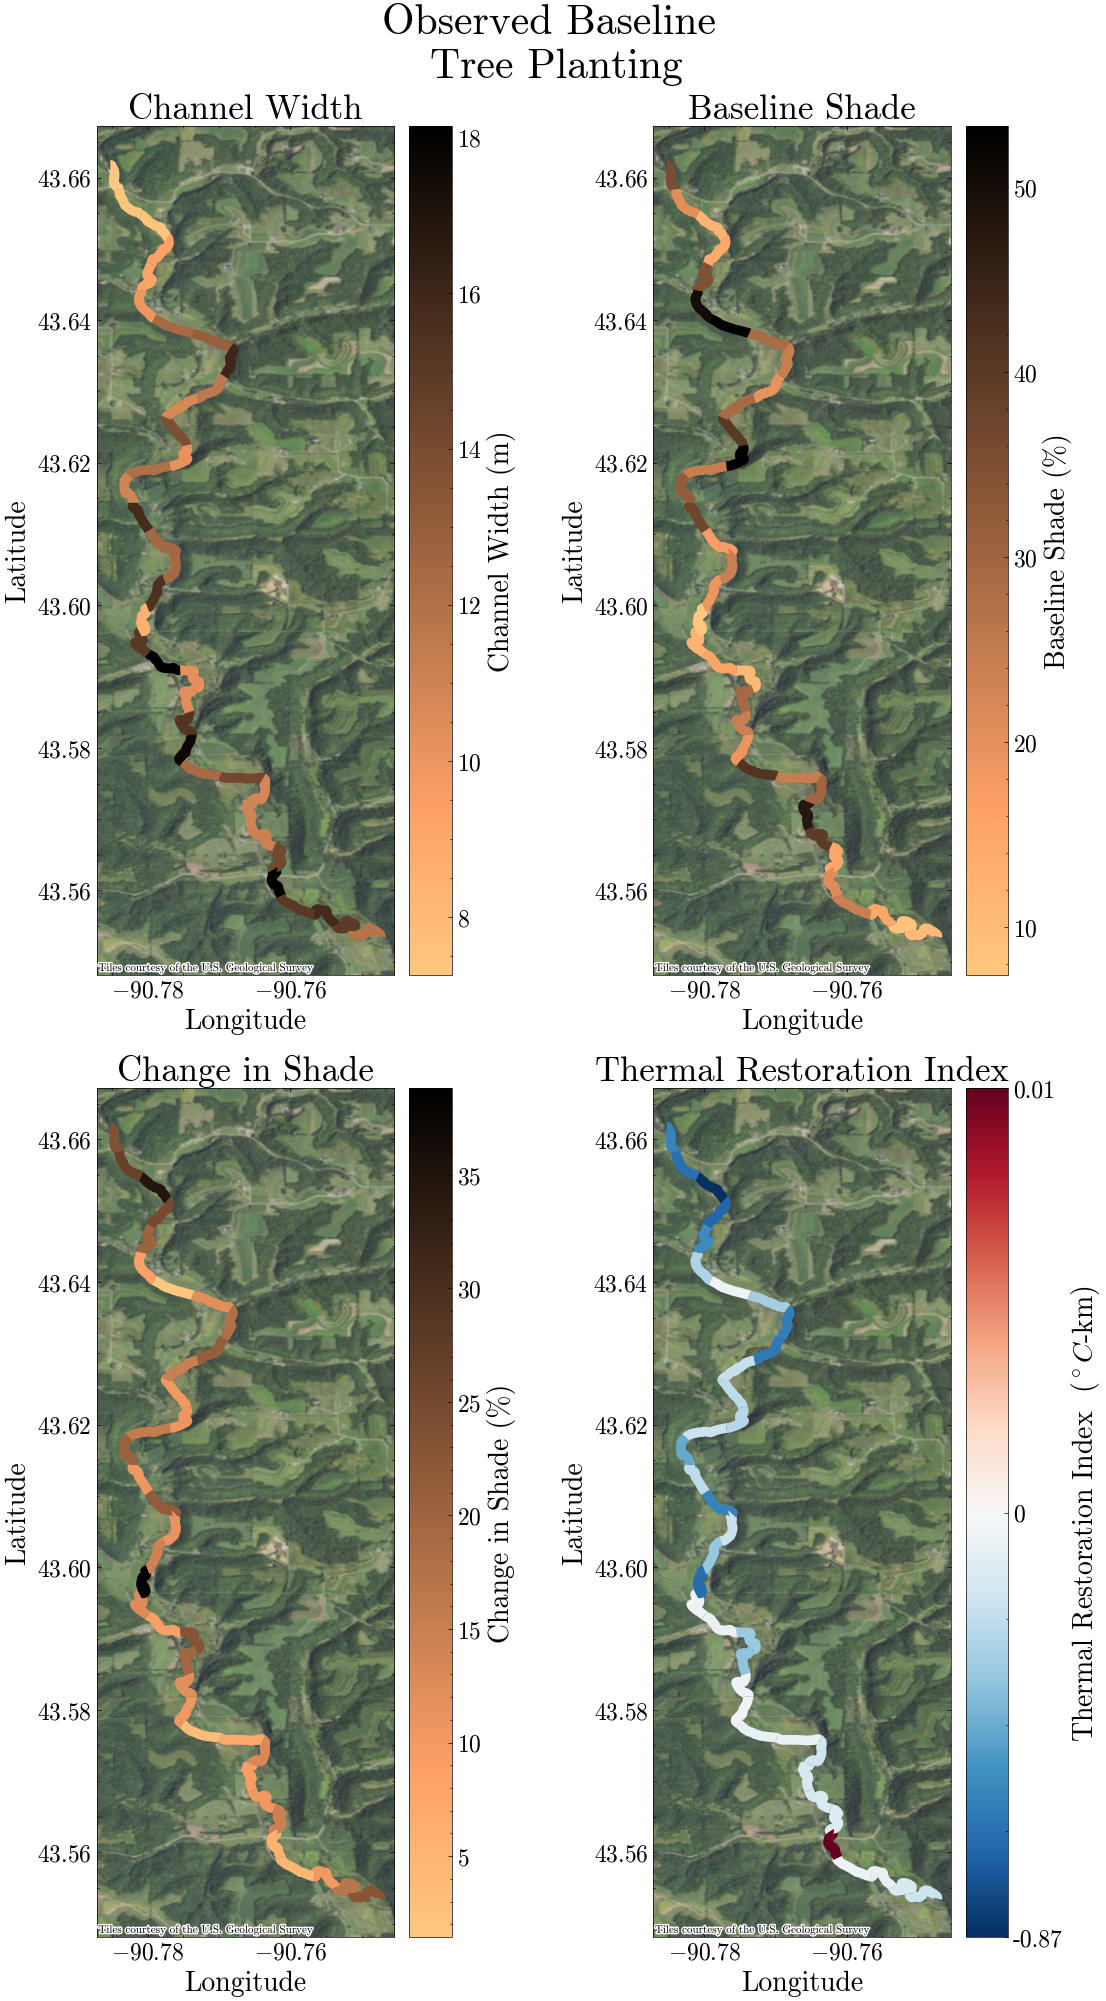

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xyzservices.providers as xyz

import contextily as ctx
import scienceplots


# Define the original colormap
original_cmap = plt.cm.copper
degree_cmap = plt.cm.RdBu
inverted_degree_cmap = degree_cmap.reversed()

# Invert the colormap
inverted_cmap = original_cmap.reversed()

# Define the boundaries for the colorbar steps
bounds_width = [merged_gdf_dif['Width'].min(), merged_gdf_dif['Width'].max()]  
bounds_dif = [merged_gdf_dif['Baseline SR'].min(), merged_gdf_dif['Baseline SR'].max()]
bounds_changeSR = [merged_gdf_dif['Change in SR'].min(), merged_gdf_dif['Change in SR'].max()]

# Create a colormap norm with the defined boundaries
norm1 = mcolors.Normalize(vmin=merged_gdf_dif['Width'].min(), vmax=merged_gdf_dif['Width'].max())
norm2 = mcolors.Normalize(vmin=merged_gdf_dif['Baseline SR'].min(), vmax=merged_gdf_dif['Baseline SR'].max())
norm3 = mcolors.Normalize(vmin=merged_gdf_dif['Change in SR'].min(), vmax=merged_gdf_dif['Change in SR'].max())
#norm4 = mcolors.Normalize(vmin=merged_gdf_dif['Degree Kilometers'].min(), vmax=merged_gdf_dif['Degree Kilometers'].max())
norm4 = mcolors.TwoSlopeNorm(vmin=merged_gdf_dif['Degree Kilometers'].min(), vcenter=0, vmax=merged_gdf_dif['Degree Kilometers'].max())

with plt.style.context(['science', 'no-latex']):
    # plotting the difference in temps between modeled reaches, with ranking
    fig, axes = plt.subplots(2, 2, figsize=(40, 20), layout = 'compressed')
    fig.suptitle('Observed Baseline \nTree Planting', fontsize=30)

    db_lonlat = merged_gdf_dif.to_crs(epsg=4326)
    #ctx.add_basemap(axes[0], crs=db_lonlat.crs)
    
    # Plot the first map
    ax1 = axes.flat[0]

    #ax1 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=5, ax=axes[0], norm=norm1)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Width', cmap=inverted_cmap, linewidth=7, ax=ax1, norm=norm1)
    
    ctx.add_basemap(ax1, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax1.set_xlabel('Longitude', fontsize = 20)
    ax1.set_ylabel('Latitude', fontsize=20)
    ax1.set_title('Channel Width', fontsize=25)
    ax1.tick_params(axis='both', which='major', labelsize=17)

    # Plot the second map
    ax2 = axes.flat[1]

    # ax2 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=5, ax=axes[1], norm=norm2)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Baseline SR', cmap=inverted_cmap, linewidth=7, ax=ax2, norm=norm2)

    ctx.add_basemap(ax2, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax2.set_title('Baseline Shade', fontsize=25)
    ax2.set_xlabel('Longitude', fontsize=20)
    ax2.set_ylabel('Latitude', fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=17)

    
    ax3 = axes.flat[2]

    # ax3 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=5, ax=axes[2], norm=norm3)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Change in SR', cmap=inverted_cmap, linewidth=7, ax=ax3, norm=norm3)

    ctx.add_basemap(ax3, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax3.set_title('Change in Shade', fontsize=25)
    ax3.set_xlabel('Longitude', fontsize=20)
    ax3.set_ylabel('Latitude', fontsize=20)
    ax3.tick_params(axis='both', which='major', labelsize=17)

    ax4 = axes.flat[3]

    # ax4 = merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=5, ax=axes[3], norm=norm4)
    merged_gdf_dif.to_crs(epsg=4326).plot(column='Degree Kilometers', cmap=inverted_degree_cmap, linewidth=7, ax=ax4, norm=norm4)

    ctx.add_basemap(ax4, source=ctx.providers.USGS.USImagery, crs=db_lonlat.crs)
    ax4.set_title('Thermal Restoration Index', fontsize=25)
    ax4.set_xlabel('Longitude', fontsize=20)
    ax4.set_ylabel('Latitude', fontsize=20)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    # Add colorbars for clarity
    # cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=axes[0], orientation='vertical')
    cbar1 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm1, cmap=inverted_cmap), ax=ax1, orientation='vertical')
    cbar1.set_label('Channel Width (m)', fontsize=20)
    cbar1.ax.tick_params(axis='both', which='major', labelsize=17)


    cbar2 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm2, cmap=inverted_cmap), ax=ax2, orientation='vertical')
    cbar2.set_label('Baseline Shade (%)', fontsize=20)
    cbar2.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar3 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm3, cmap=inverted_cmap), ax=ax3, orientation='vertical')
    cbar3.set_label('Change in Shade (%)', fontsize=20)
    cbar3.ax.tick_params(axis='both', which='major', labelsize=17)

    cbar4 = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm4, cmap=inverted_degree_cmap), ax=ax4, orientation='vertical')
    cbar4.set_label('Thermal Restoration Index  (${^\circ}C$-km)', fontsize=20)
    cbar4.ax.tick_params(axis='both', which='major', labelsize=17)
    cbar4.set_ticks([merged_gdf_dif['Degree Kilometers'].min(), 0, merged_gdf_dif['Degree Kilometers'].max()])
    cbar4.ax.set_yticklabels([f'{merged_gdf_dif["Degree Kilometers"].min():.2f}', '0', f'{merged_gdf_dif["Degree Kilometers"].max():.2f}'])


    #plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\500mTreePlantingEffectiveness.png', bbox_inches='tight', dpi=300)
    #plt.savefig(os.path.join(script_dir, 'Figures', 'TreePlantingMapObservedWiden20.png'), bbox_inches='tight', dpi=300)

    plt.show()


# Regression analysis

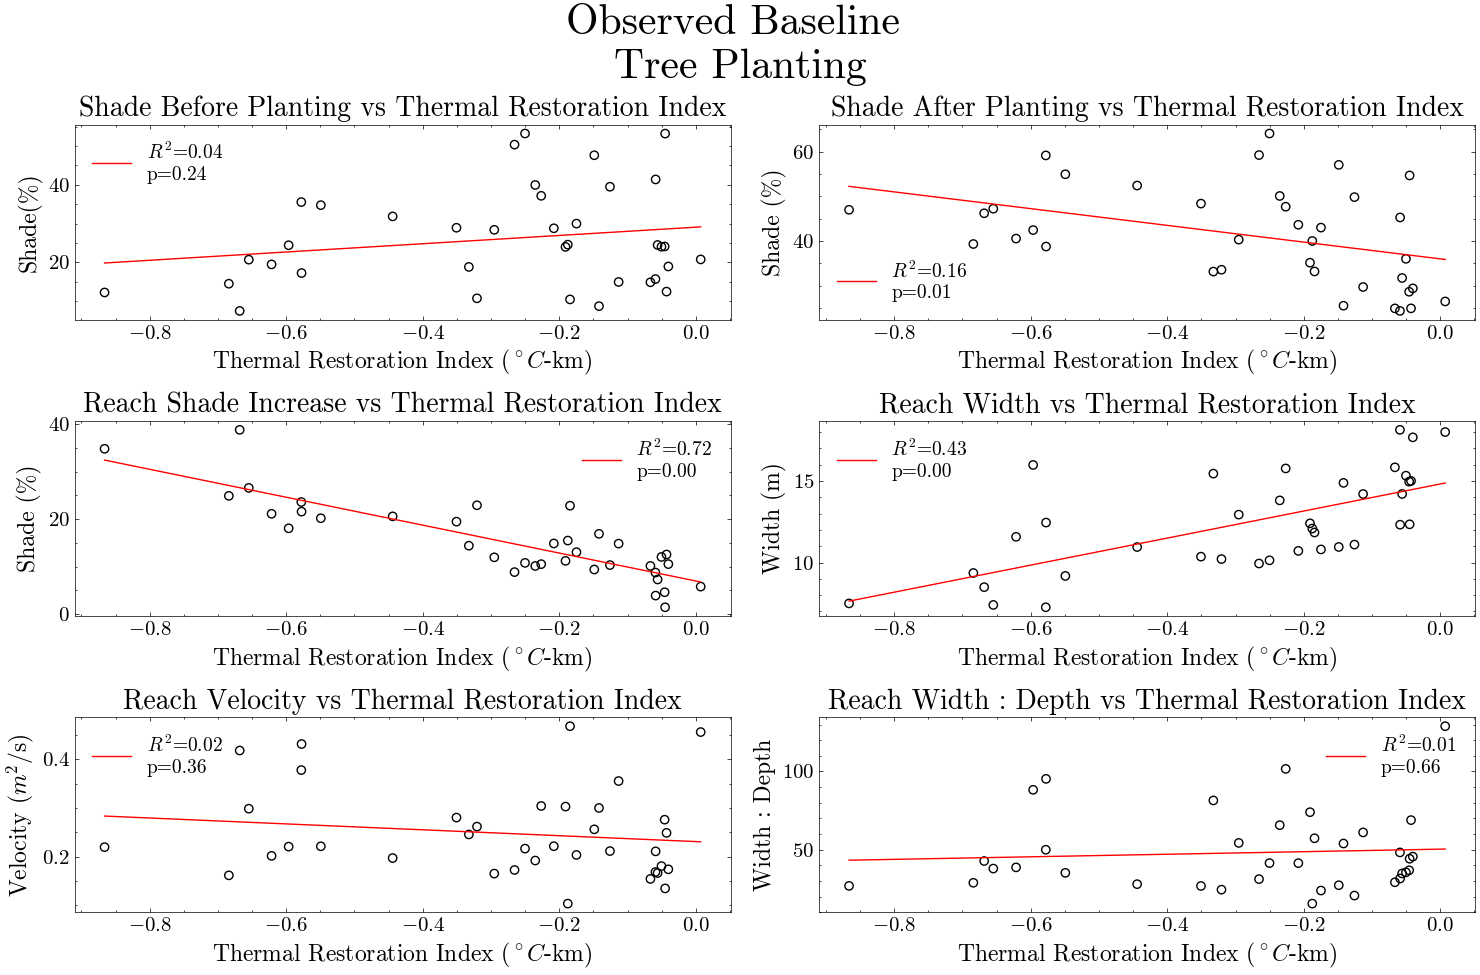

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

# Assuming dif_df_dict contains your data

# Define a function for plotting
def plot_scatter_and_regression(x_data, y_data, x_label, y_title, y_label, ax):
    with plt.style.context(['science', 'no-latex']):
        #x_data = x_data*-1
        # Fitting linear regression
        model = LinearRegression()
        model.fit(x_data, y_data)
        r_squared = model.score(x_data, y_data)

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = linregress(x_data.ravel(), y_data)

        # Scatter plot
        ax.scatter(x_data, y_data, facecolors='none', edgecolors='black')

        # Plotting the regression line
        ax.plot(x_data, model.predict(x_data), color='red', linestyle = '-',label=f'$R^2$={r_squared:.2f} \np={p_value:.2f}')
        ax.set_title(y_title+ ' vs Thermal Restoration Index', fontsize = 20)
        # Labels and legend
        ax.set_xlabel(x_label, fontsize = 17)
        ax.set_ylabel(y_label, fontsize = 17)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.legend(fontsize = 14)
with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle('Observed Baseline \nTree Planting', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Baseline SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Shade Before Planting',  'Shade(%)', axs[0, 0])

    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Scenario SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Shade After Planting', 'Shade (%)', axs[0, 1])

    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Change in SR'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Shade Increase', 'Shade (%)', axs[1, 0])

    # Plot 2 (Assuming you have dif_df_dict2, dif_df_dict3, dif_df_dict4 for other data)
    # Adjust accordingly based on your actual data
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Width', 'Width (m)', axs[1, 1])

    # Plot 3
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                dif_df_dict['Mean velocity'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Velocity', 'Velocity ($m{^2}$/s)', axs[2, 0])

    # Plot 4
    plot_scatter_and_regression(dif_df_dict['Degree Kilometers'].values.reshape(-1, 1),
                                 dif_df_dict['Width:Depth'].values,
                                 'Thermal Restoration Index (${^\circ}C$-km)', 'Reach Width : Depth', 'Width : Depth', axs[2, 1])

    # Adjust layout
    plt.tight_layout()
    #plt.savefig(os.path.join(script_dir, 'Figures', 'TreePlantingRegressionObservedWiden20.png'), bbox_inches='tight', dpi=300)
    # Show plot
    plt.show()

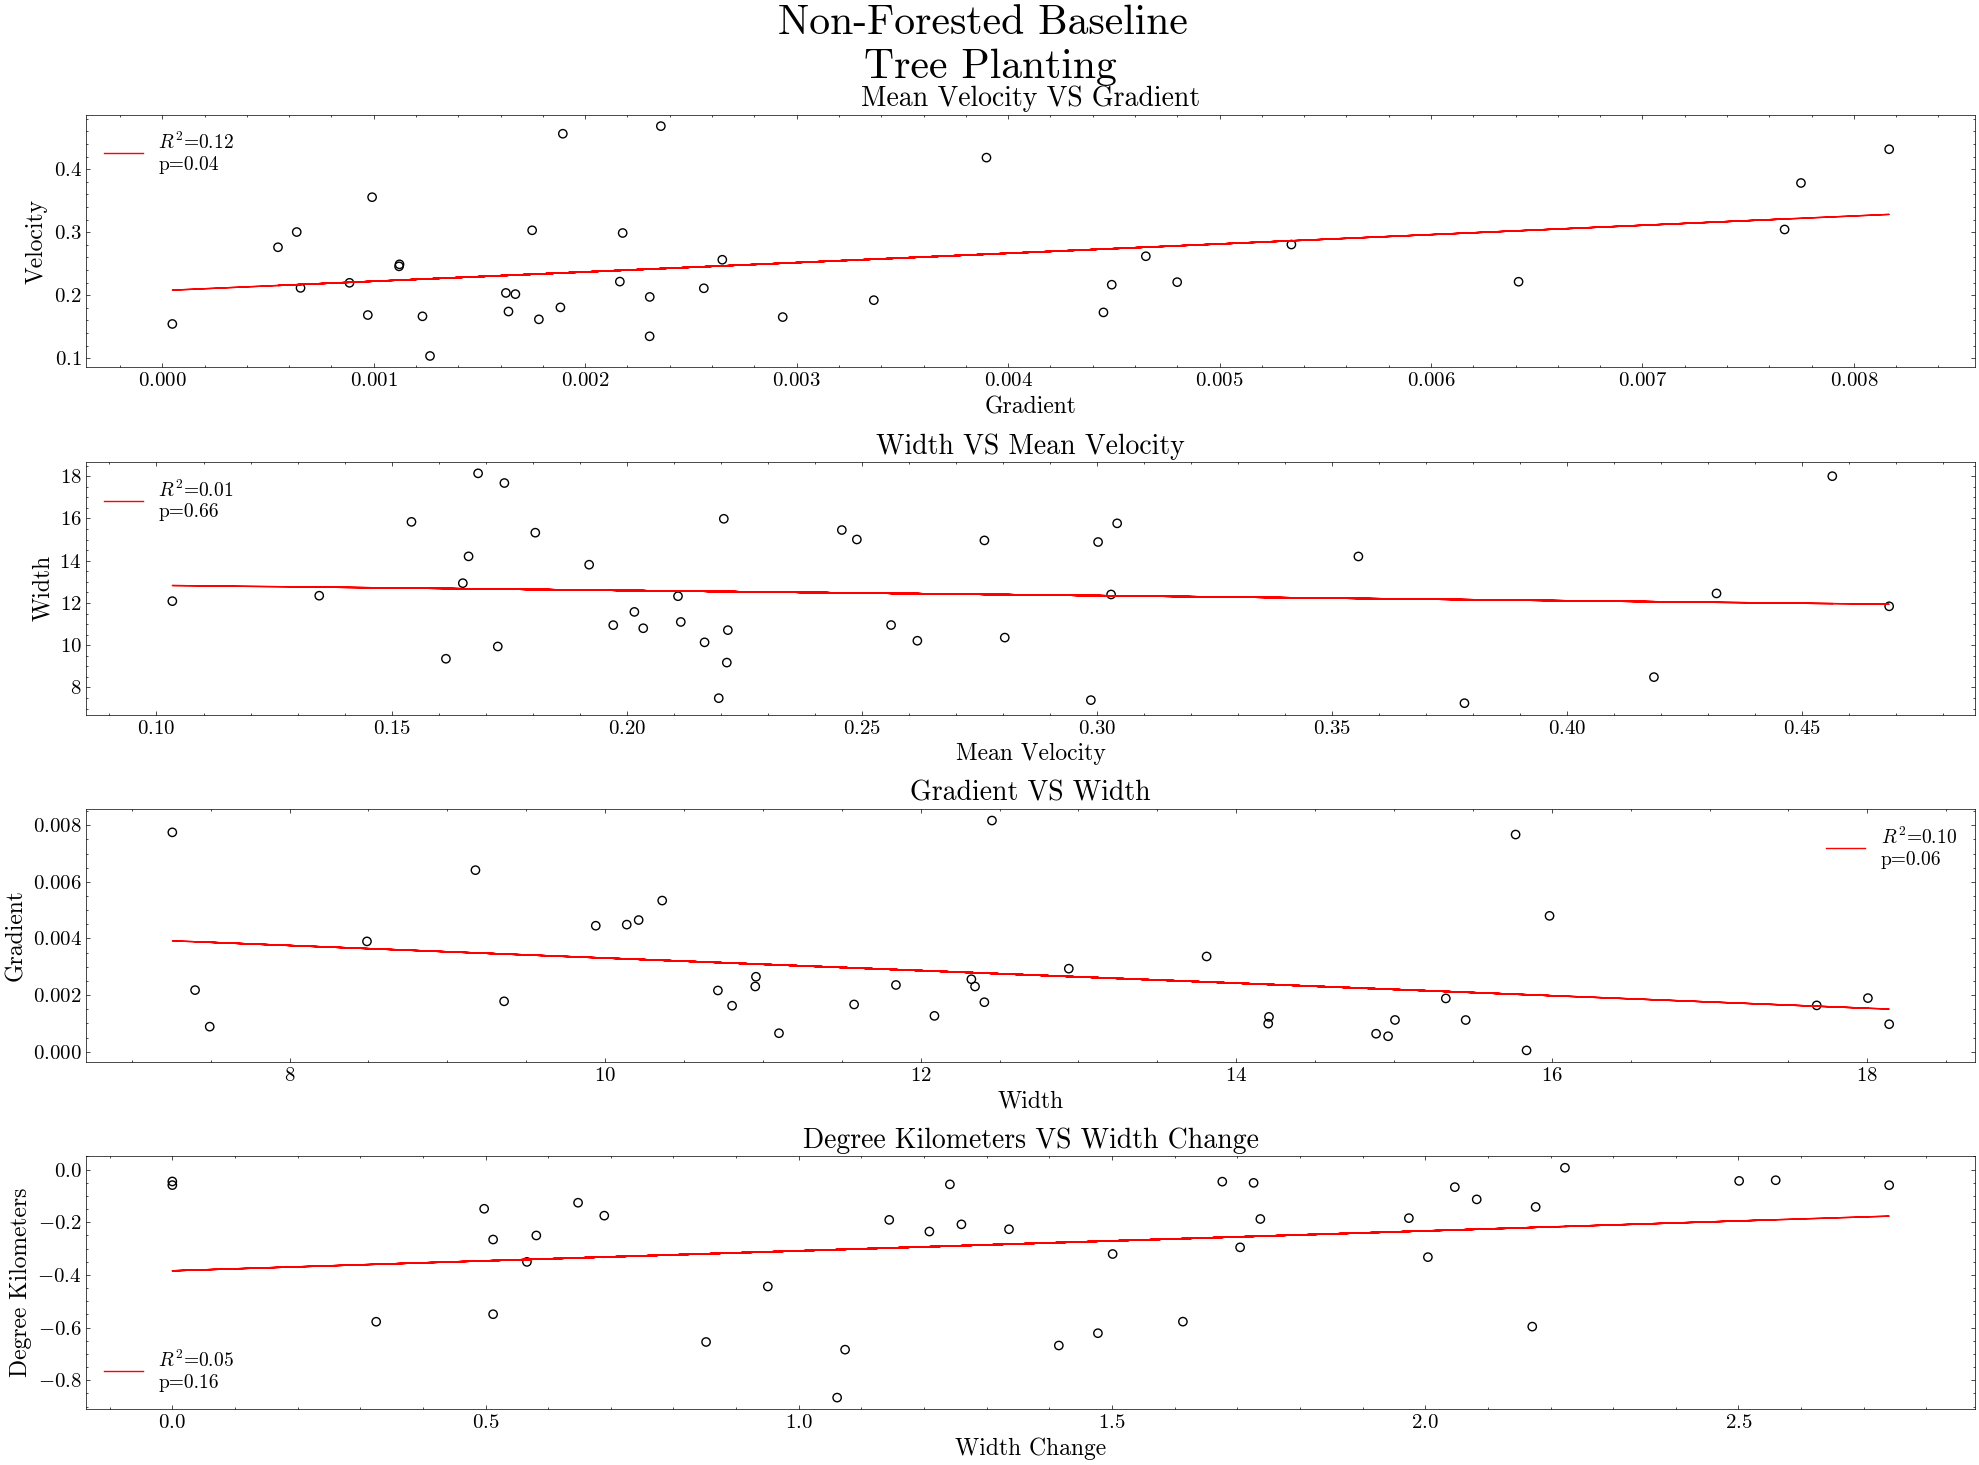

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

# Assuming dif_df_dict contains your data

# Define a function for plotting
def plot_scatter_and_regression(x_data, y_data, x_label, y_title, y_label, ax):
    with plt.style.context(['science', 'no-latex']):
        #x_data = x_data*-1
        # Fitting linear regression
        model = LinearRegression()
        model.fit(x_data, y_data)
        r_squared = model.score(x_data, y_data)

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = linregress(x_data.ravel(), y_data)

        # Scatter plot
        ax.scatter(x_data, y_data, facecolors='none', edgecolors='black')

        # Plotting the regression line
        ax.plot(x_data, model.predict(x_data), color='red', linestyle = '-',label=f'$R^2$={r_squared:.2f} \np={p_value:.2f}')
        ax.set_title(y_title+ ' VS ' + x_label, fontsize = 20)
        # Labels and legend
        ax.set_xlabel(x_label, fontsize = 17)
        ax.set_ylabel(y_label, fontsize = 17)
        ax.tick_params(axis='both', which='major', labelsize=15)

        ax.legend(fontsize = 14)
with plt.style.context(['science', 'no-latex']):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(4, 1, figsize=(20, 15))
    fig.suptitle('Non-Forested Baseline \nTree Planting', fontsize=30)

    # Plot 1
    plot_scatter_and_regression(dif_df_dict['Gradient'].values.reshape(-1, 1),
                                 dif_df_dict['Mean velocity'].values,
                                 'Gradient', 'Mean Velocity',  'Velocity', axs[0])

    plot_scatter_and_regression(dif_df_dict['Mean velocity'].values.reshape(-1, 1),
                                 dif_df_dict['Width'].values,
                                 'Mean Velocity', 'Width', 'Width', axs[1])
    plot_scatter_and_regression(dif_df_dict['Width'].values.reshape(-1, 1),
                                 dif_df_dict['Gradient'].values,
                                 'Width', 'Gradient', 'Gradient', axs[2])
    plot_scatter_and_regression(dif_df_dict['Width Change'].values.reshape(-1, 1),
                                 dif_df_dict['Degree Kilometers'].values,
                                 'Width Change', 'Degree Kilometers', 'Degree Kilometers', axs[3])



    # Adjust layout
    plt.tight_layout()
    #plt.savefig(os.path.join(script_dir, 'Figures', 'SlopeVelocityWidthRelationships_treeplant.png'), bbox_inches='tight', dpi=300)
    # Show plot
    plt.show()

# Effectiveness maps
- map of effectiveness ranks
- map of degree kilometer change 

# Plotting the top 10 shade reaches implemented vs observed july temps
- i think i need to work on these scenarios - change morphology and landcover in 10 reaches , i think i only did 5


## In a new blank scenario run from july_monthly base,  adding the landcover and morphology attributes from the top 10 most effective reaches

In [33]:
# Finding the top 10 reaches from sorted effeciveness df

km_list = []
for index, row in dif_df_dict.head(10).iterrows(): ## dif_df_dict is sorted by effectiveness rank so the first 10 rows are the top 10 most effective restoration reaches
    km_list.append(row['Model Start KM'])
km_list

[17.0, 16.5, 6.0, 15.0, 12.0, 8.0, 17.5, 14.0, 13.0, 14.5]

In [32]:
#folder of top 10 scenario i want to fill with reach by reach scenario data
for i in km_list:
    top10_source = os.path.abspath(os.path.join(script_dir, 'scenarios', 'top10_treeplanting'))
    landcover_top10 = pd.read_csv(os.path.join(top10_source, 'inputs\WFK23_lcdata.csv'))
    morhpology_top10 = pd.read_csv(os.path.join(top10_source, 'inputs\WFK23_morphology.csv'))
    # loop to getlandcover files for the top 10 
    km_start = i- 5.0
    km_end = km_start - .5
    #reach files
    reach_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','scenario_outputs', 'observed_baseline', 'baseline_treeplanting_widen20_7mtree', f'treeplanting_widen20_7mtree_{i}'))
    landcover_reach = pd.read_csv(os.path.join(reach_source_folder, 'inputs\WFK23_lcdata.csv'))
    morphology_reach = pd.read_csv(os.path.join(reach_source_folder, 'inputs\WFK23_morphology.csv'))
    reach = landcover_top10[(landcover_top10['STREAM_KM'] <= km_start) & (landcover_top10['STREAM_KM']>km_end)]
    print(reach)
    #loop through each row in reach and change landcover and morphology to forest
    for index, row in reach.iterrows():
        #write landcover from shade scenario to top10 scenario
        landcover_top10.loc[index, landcover_top10.columns[8:49]] = landcover_reach.loc[index, landcover_reach.columns[8:49]]
        landcover_top10.to_csv(os.path.join(top10_source, 'inputs\WFK23_lcdata.csv'), index = False)

        # write morphology from shade landcover scenario to top10 scenario
        morhpology_top10.loc[index,morhpology_top10.columns[5]] = morphology_reach.loc[index,morphology_reach.columns[5]]
        morhpology_top10.to_csv(os.path.join(top10_source, 'inputs\WFK23_morphology.csv'), index = False)


    STREAM_ID  NODE_ID  STREAM_KM  LONGITUDE   LATITUDE     TOPO_W    TOPO_S  \
15        NaN      170       17.0 -90.777319  43.651727  12.271638  4.325671   
16        NaN      169       16.9 -90.776991  43.650888  10.994276  2.850032   
17        NaN      168       16.8 -90.777613  43.650188   9.304401  2.439189   
18        NaN      167       16.7 -90.778196  43.649420   9.832169  2.525391   
19        NaN      166       16.6 -90.778923  43.648744   8.651086  2.518271   

       TOPO_E  LC_T0_S0  LC_T1_S1  ...  ELE_T7_S1  ELE_T7_S2  ELE_T7_S3  \
15   5.684218        -1        -2  ...  285.71417  285.71417  285.63810   
16   7.907629        -1        -1  ...  285.64645  285.70883  285.77680   
17  10.425071        -1        -1  ...  285.51944  285.54895  285.60605   
18  13.637520        -1        -1  ...  285.51282  285.51282  285.51282   
19  19.066663        -1        -1  ...  285.36660  285.94824  285.94824   

    ELE_T7_S4  ELE_T7_S5  ELE_T8_S1  ELE_T8_S2  ELE_T8_S3  ELE_T8_S4

## Calculating temp metrics for base and scenario models 

In [52]:
control_file = pd.read_csv(os.path.join(top10_source, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
#obs = pd.read_csv(r"D:\Ben_wd\THESIS\streamtemperature\WFK23\Summer23\mainstemhourly_km.csv")
obs["datetime"] = pd.to_datetime(obs["datetime"])
#obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]<'07-02-2023')]# + pd.DateOffset(1))]
obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
cc_end

Timestamp('2023-07-31 00:00:00')

In [54]:
base_tw_df

Empty DataFrame
Columns: [18.5, 18.4, 18.3, 18.2, 18.1, 18.0, 17.9, 17.8, 17.7, 17.6, 17.5, 17.4, 17.3, 17.2, 17.1, 17.0, 16.9, 16.8, 16.7, 16.6, 16.5, 16.4, 16.3, 16.2, 16.1, 16.0, 15.9, 15.8, 15.7, 15.6, 15.5, 15.4, 15.3, 15.2, 15.1, 15.0, 14.9, 14.8, 14.7, 14.6, 14.5, 14.4, 14.3, 14.2, 14.1, 14.0, 13.9, 13.8, 13.7, 13.6, 13.5, 13.4, 13.3, 13.2, 13.1, 13.0, 12.9, 12.8, 12.7, 12.6, 12.5, 12.4, 12.3, 12.2, 12.1, 12.0, 11.9, 11.8, 11.7, 11.6, 11.5, 11.4, 11.3, 11.2, 11.1, 11.0, 10.9, 10.8, 10.7, 10.6, 10.5, 10.4, 10.3, 10.2, 10.1, 10.0, 9.9, 9.8, 9.7, 9.6, 9.5, 9.4, 9.3, 9.2, 9.1, 9.0, 8.9, 8.8, 8.7, 8.6, ...]
Index: []

[0 rows x 184 columns]

In [87]:
# read in top10 scenario temps
top10_tw_df = pd.read_csv(os.path.join(top10_source, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 187))
top10_tw_df.columns = [float(col) for col in top10_tw_df.columns]
top10_tw_df.index = obs_clip.index

#read in baseline model temps
base_tw_df = pd.read_csv(os.path.join(script_dir,'scenarios', 'scenario_inputs',  'baseline_vegetation', 'july_baseline', 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 187))
base_tw_df.columns = [float(col) for col in base_tw_df.columns]
base_tw_df.index = obs_clip.index

#mean & max july
mean_daily_top10 = top10_tw_df.resample('D').mean()
max_daily_top10 = top10_tw_df.resample('D').max()

mean_daily_base = base_tw_df.resample('D').mean()
max_daily_base = base_tw_df.resample('D').max()

#adding MWAT for modeled and observed temps
top10_mwat = mean_daily_top10.rolling(window=7).mean()
top10_mwat = top10_mwat.max()
top10_mwat = pd.DataFrame(top10_mwat)

base_mwat = mean_daily_base.rolling(window=7).mean()
base_mwat = base_mwat.max()
base_mwat = pd.DataFrame(base_mwat)

#adding MWMT
top10_mwmt = max_daily_top10.rolling(window=7).mean()
top10_mwmt = top10_mwmt.max()
top10_mwmt = pd.DataFrame(top10_mwmt)

base_mwmt = max_daily_base.rolling(window=7).mean()
base_mwmt = base_mwmt.max()
base_mwmt = pd.DataFrame(base_mwmt)

### Plotting scenario next to 2023 July baseline

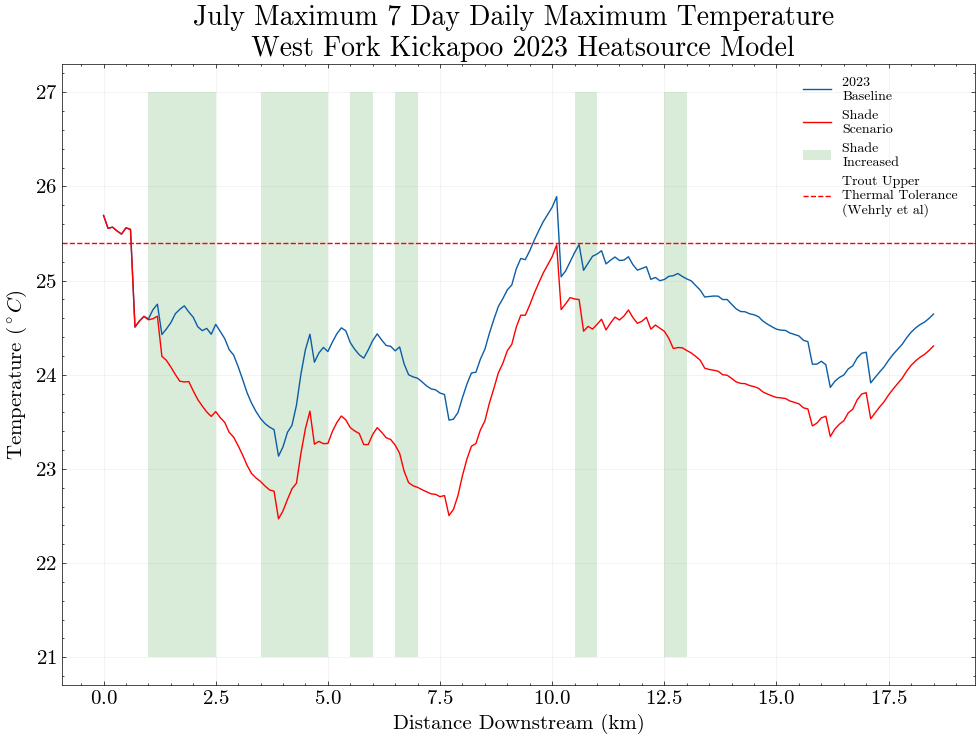

In [88]:
## July MWMT

with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(18.5 - base_mwmt.index, base_mwmt[0], label='2023 \nBaseline')
    plt.plot(18.5 - top10_mwmt.index, top10_mwmt[0], label='Shade \nScenario', color = 'red')
    for i in km_list:
        if i == 16.5:
            plt.fill_between([18.5 - i, 18.5 - (i-.5)], 21,27, color='green', edgecolor = None, alpha = .15, label = 'Shade \nIncreased')
        else:
            plt.fill_between([18.5 - i, 18.5 - (i-.5)], 21,27, color='green', edgecolor = None, alpha = .15)
    # dumb way to add a single label for shade additions
    #plt.fill_between([2, 2.5], 18,28, color='green', alpha = .15, label = 'Additional \nShading')

    x = np.linspace(-1,18.8,10)
    # plt.fill_between(x,25, 23.5, color = 'red', alpha = .2, label='Trout Upper Thermal Tolerance \n(Wehrly et al)')
    plt.ylabel('Temperature (${^\circ}C$)', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream (km)', size = 15)
    #plt.figure(facecolor='black')
    plt.axhline(y=25.4, linestyle='--', color='red', label='Trout Upper \nThermal Tolerance \n(Wehrly et al)')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    #plt.ylim(19, 21.5)
    # plt.xlim(-.5, 18.8)

    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 10)
    plt.title('July Maximum 7 Day Daily Maximum Temperature \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.savefig(os.path.join(script_dir, 'Figures', 'TreePlantingTop10MWMT.png'), bbox_inches='tight', dpi=300)

    #plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Top10JulyMaxTemp.png',bbox_inches='tight', dpi=300)
    plt.show()
    

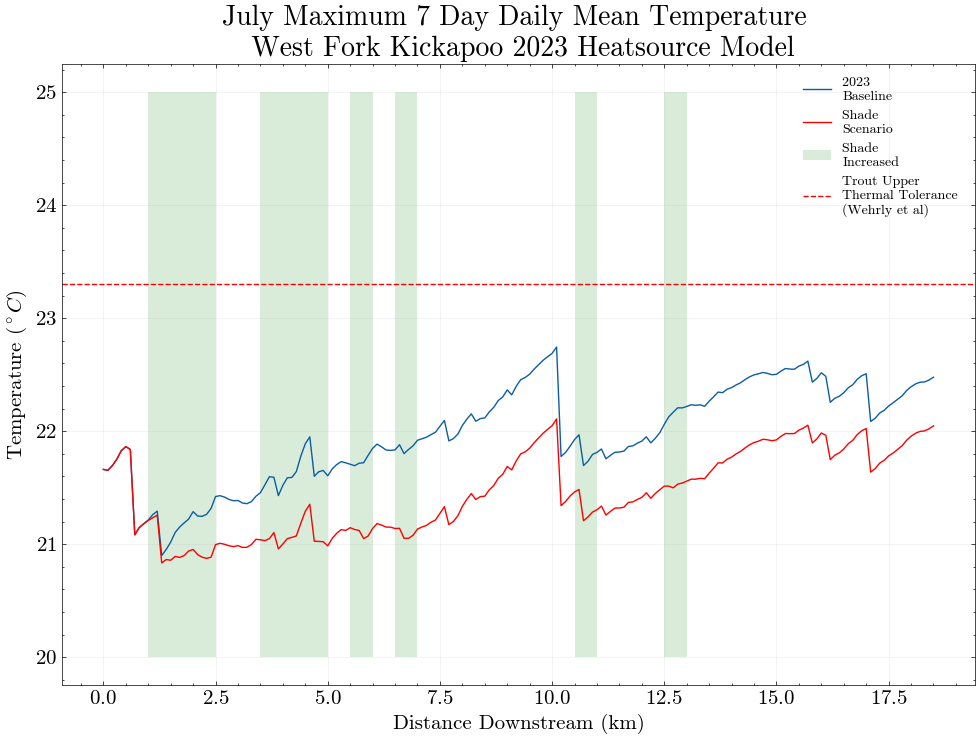

In [89]:
## July MWMT

with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(18.5 - base_mwat.index, base_mwat[0], label='2023 \nBaseline')
    plt.plot(18.5 - top10_mwat.index, top10_mwat[0], label='Shade \nScenario', color = 'red')
    for i in km_list:
        if i == 16.5:
            plt.fill_between([18.5 - i, 18.5 - (i-.5)], 20,25, color='green', edgecolor = None, alpha = .15, label = 'Shade \nIncreased')
        else:
            plt.fill_between([18.5 - i, 18.5 - (i-.5)], 20,25, color='green', edgecolor = None, alpha = .15)
    # dumb way to add a single label for shade additions
    #plt.fill_between([2, 2.5], 18,28, color='green', alpha = .15, label = 'Additional \nShading')

    x = np.linspace(-1,18.8,10)
    # plt.fill_between(x,25, 23.5, color = 'red', alpha = .2, label='Trout Upper Thermal Tolerance \n(Wehrly et al)')
    plt.ylabel('Temperature (${^\circ}C$)', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream (km)', size = 15)
    #plt.figure(facecolor='black')
    plt.axhline(y=23.3, linestyle='--', color='red', label='Trout Upper \nThermal Tolerance \n(Wehrly et al)')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    #plt.ylim(19, 21.5)
    # plt.xlim(-.5, 18.8)

    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 10)
    plt.title('July Maximum 7 Day Daily Mean Temperature \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.savefig(os.path.join(script_dir, 'Figures', 'TreePlantingTop10MWAT.png'), bbox_inches='tight', dpi=300)

    #plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Top10JulyMaxTemp.png',bbox_inches='tight', dpi=300)
    plt.show()
    

## Finding days above MWAT and MWMT Temp Thresholds

In [97]:
#MWaT BASELINE
# base_mwat = mean_daily_base.rolling(window=7).max()
mean_daily_base = base_tw_df.resample('D').max()
base_mwat = mean_daily_base.rolling(window=7).mean()
scenario_mwat = mean_daily_top10.rolling(window=7).mean()

basemwat_above_threshold = base_mwat.apply(lambda col: (col > 23.3).sum())
basemwat_above_threshold = pd.DataFrame(basemwat_above_threshold)
basemwat_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 23.3'}, inplace=True)

#MWMT BASELINE

#upstreamconstant_df.index = obs_clip_day.index
max_daily_base = base_tw_df.resample('D').max()
base_mwmt = max_daily_base.rolling(window=7).mean()
basemwmt_above_threshold = base_mwmt.apply(lambda col: (col > 25.4).sum())
basemwmt_above_threshold = pd.DataFrame(basemwmt_above_threshold)
basemwmt_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 25.4'}, inplace=True)

basemwat_above_threshold


Days > 23.3
18.5           13
18.4           12
18.3           12
18.2           12
18.1           12
...           ...
0.4             6
0.3             6
0.2             6
0.1             6
0.0             6

[186 rows x 1 columns]

In [91]:
#MWAT Scenario

#mean & max july
mean_daily_top10 = top10_tw_df.resample('D').mean()
scenario_mwat = mean_daily_top10.rolling(window=7).mean()
scenario_mwat
#scenario_mwat.rename(columns={'index': 'NODE_ID', 0 : 'MWAT'}, inplace=True)
scenariomwat_above_threshold = scenario_mwat.apply(lambda col: (col > 23.3).sum())
scenariomwat_above_threshold = pd.DataFrame(scenariomwat_above_threshold)
scenariomwat_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 23.3'}, inplace=True)

# #MWMT scenaroi

max_daily_top10 = top10_tw_df.resample('D').max()
scenario_mwmt = max_daily_top10.rolling(window=7).mean()
scenariomwmt_above_threshold = scenario_mwmt.apply(lambda col: (col > 25.4).sum())
scenariomwmt_above_threshold = pd.DataFrame(scenariomwmt_above_threshold)
scenariomwmt_above_threshold.rename(columns={'index': 'NODE_ID', 0 : 'Days > 25.4'}, inplace=True)

scenariomwat_above_threshold

Days > 23.3
18.5            0
18.4            0
18.3            0
18.2            0
18.1            0
...           ...
0.4             0
0.3             0
0.2             0
0.1             0
0.0             0

[186 rows x 1 columns]

## Plotting Days above Threshold Base and Scenario

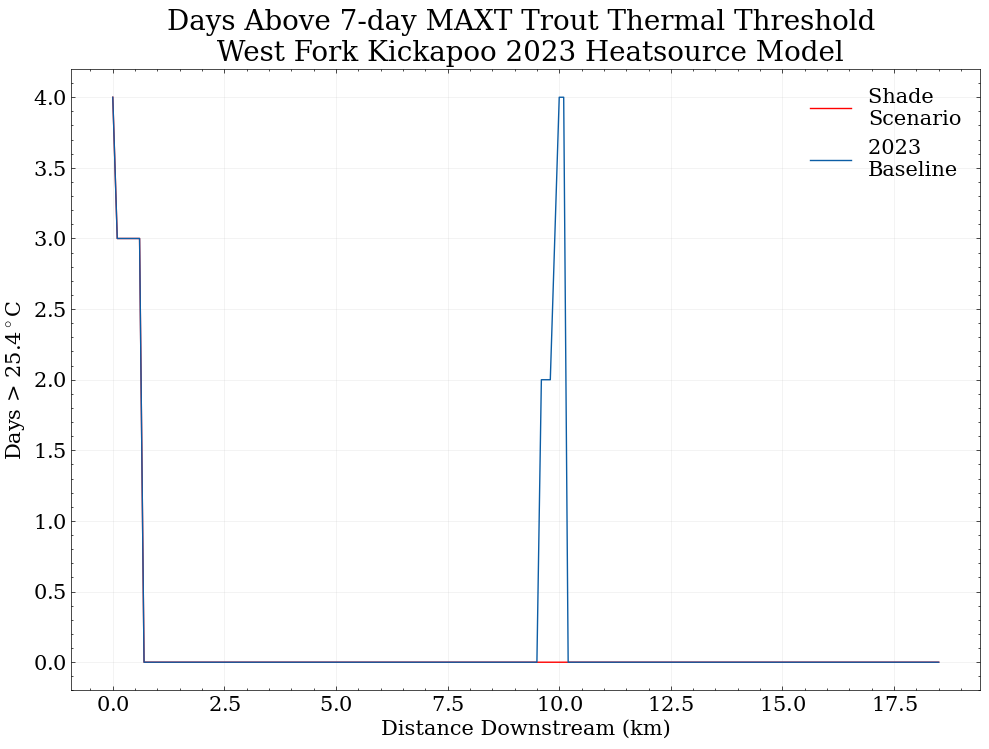

In [104]:
with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(18.5-scenariomwmt_above_threshold.index, scenariomwmt_above_threshold['Days > 25.4'], label=f'Shade \nScenario', color = 'red')
    plt.plot(18.5-basemwmt_above_threshold.index, basemwmt_above_threshold['Days > 25.4'], label='2023 \nBaseline')
    plt.ylabel('Days > 25.4${^\circ}$C', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream (km)', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.legend(loc = 'upper right', fontsize = 15)
    plt.title('Days Above 7-day MAXT Trout Thermal Threshold \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.grid(alpha = .2)
    plt.savefig(os.path.join(script_dir, 'Figures', 'TreePlantingDaysaboveMWMT.png'), bbox_inches='tight', dpi=300)

    #plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\DaysAboveMWMTThreshold.png',bbox_inches='tight', dpi=300)

# axes[count-1].set_title(f'Hours above 22.3 - Shade added between {km_start} km and {km_end} km')
# axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
# axes[count-1].set_ylabel('Hours')  # Replace 'Y Label' with appropriate label


In [101]:
basemwmt_above_threshold

Days > 25.4
18.5            4
18.4            3
18.3            3
18.2            3
18.1            3
...           ...
0.4             0
0.3             0
0.2             0
0.1             0
0.0             0

[186 rows x 1 columns]

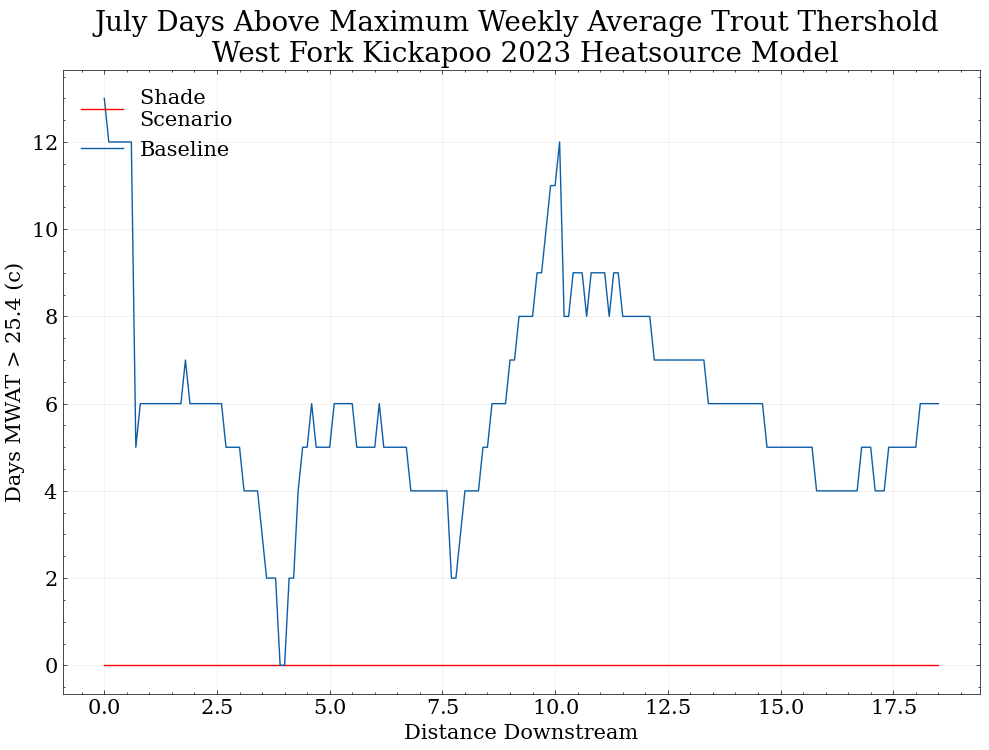

In [103]:
with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize=(10, 7))
    plt.plot(18.5-scenariomwat_above_threshold.index, scenariomwat_above_threshold['Days > 23.3'], label=f'Shade \nScenario', color = 'red')
    plt.plot(18.5-basemwat_above_threshold.index, basemwat_above_threshold['Days > 23.3'], label='Baseline')
    plt.ylabel('Days MWAT > 25.4 (c)', size = 15)
    plt.yticks(size= 15)
    plt.xticks(size= 15)

    plt.xlabel('Distance Downstream', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.legend(loc = 'upper left', fontsize = 15)
    plt.title('July Days Above Maximum Weekly Average Trout Thershold \n West Fork Kickapoo 2023 Heatsource Model', size =20)
    plt.grid(alpha = .2)
    #plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\ModelOutputs\DaysAboveMWATThreshold.png',bbox_inches='tight', dpi=300)

# axes[count-1].set_title(f'Hours above 22.3 - Shade added between {km_start} km and {km_end} km')
# axes[count-1].set_xlabel('Downstream KM')  # Replace 'X Label' with appropriate label
# axes[count-1].set_ylabel('Hours')  # Replace 'Y Label' with appropriate label


## Plotting a map down here possibly? Need Node shapefile though

In [ ]:
nodes = gpd.read_file(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/shp/restoration_reaches500m.shp')

MWAT_threshold = pd.merge(merged_gdf_dif, MWMT_difference, left_on='row', right_index = True, how='left')
